In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report as cr, confusion_matrix as cm, accuracy_score
from sklearn.preprocessing import LabelEncoder


In [29]:
uber = pd.read_csv('C:\\Users\\HP-1\\OneDrive\\Desktop\\SIT\\Projects\\UberAnalysis\\datasets\\UberDataset.csv')
uber.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [30]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   object 
 4   STOP        1155 non-null   object 
 5   MILES       1156 non-null   float64
 6   PURPOSE     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


In [31]:
uber.describe()

,MILES
count,1156.000000
mean,21.115398
std,359.299007
min,0.500000
25%,2.900000
50%,6.000000
75%,10.400000
max,12204.700000


In [32]:
uber.isnull().sum()

START_DATE      0
END_DATE        1
CATEGORY        1
START           1
STOP            1
MILES           0
PURPOSE       503
dtype: int64

In [35]:
print(uber[uber['START_DATE'].isna()].head(10))
print(uber[uber['END_DATE'].isna()].head(10))


   START_DATE END_DATE  CATEGORY  ...                 STOP MILES          PURPOSE
23        NaT      NaT  Business  ...              Gulfton  11.2          Meeting
24        NaT      NaT  Business  ...             Downtown  11.8          Meeting
25        NaT      NaT  Business  ...              Houston  21.9   Customer Visit
26        NaT      NaT  Business  ...      Jamestown Court   3.9  Errand/Supplies
27        NaT      NaT  Business  ...                 Cary   8.0  Errand/Supplies
28        NaT      NaT  Business  ...               Durham  10.4   Meal/Entertain
29        NaT      NaT  Business  ...                 Cary  10.4   Meal/Entertain
30        NaT      NaT  Business  ...                 Cary   4.8   Meal/Entertain
31        NaT      NaT  Business  ...          Whitebridge   4.7   Meal/Entertain
32        NaT      NaT  Business  ...  Lake Wellingborough   7.2              NaN

[10 rows x 7 columns]
   START_DATE END_DATE  CATEGORY  ...                 STOP MILES          P

In [36]:
uber['START_DATE'] = pd.to_datetime(uber['START_DATE'], errors='coerce', infer_datetime_format=True)
uber['END_DATE'] = pd.to_datetime(uber['END_DATE'], errors='coerce', infer_datetime_format=True)


C:\Users\HP-1\AppData\Local\Temp\ipykernel_4040\1798382159.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  uber['START_DATE'] = pd.to_datetime(uber['START_DATE'], errors='coerce', infer_datetime_format=True)
C:\Users\HP-1\AppData\Local\Temp\ipykernel_4040\1798382159.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  uber['END_DATE'] = pd.to_datetime(uber['END_DATE'], errors='coerce', infer_datetime_format=True)


In [37]:
print(f"Missing START_DATE after parsing: {uber['START_DATE'].isna().sum()}")
print(f"Missing END_DATE after parsing: {uber['END_DATE'].isna().sum()}")

Missing START_DATE after parsing: 735
Missing END_DATE after parsing: 736


In [38]:
uber = uber.dropna(subset=['START_DATE', 'END_DATE'])
print(f"Remaining rows after dropping: {len(uber)}")


Remaining rows after dropping: 420


In [40]:
uber.reset_index(drop=True, inplace=True)


In [41]:
print(uber['START_DATE'].isna().sum())  # Should be 0
print(uber['END_DATE'].isna().sum())    # Should be 0


0
0


In [43]:
uber.shape

(420, 7)

In [ ]:
uber['Trip_Duration_Min'] = (uber['END_DATE'] - uber['START_DATE']).dt.total_seconds() / 60

uber['Month'] = uber['START_DATE'].dt.month
uber['DayOfWeek'] = uber['START_DATE'].dt.day_name()
uber['Hour'] = uber['START_DATE'].dt.hour


# Exploratory Data Analysis

1. Distribution of trip durations

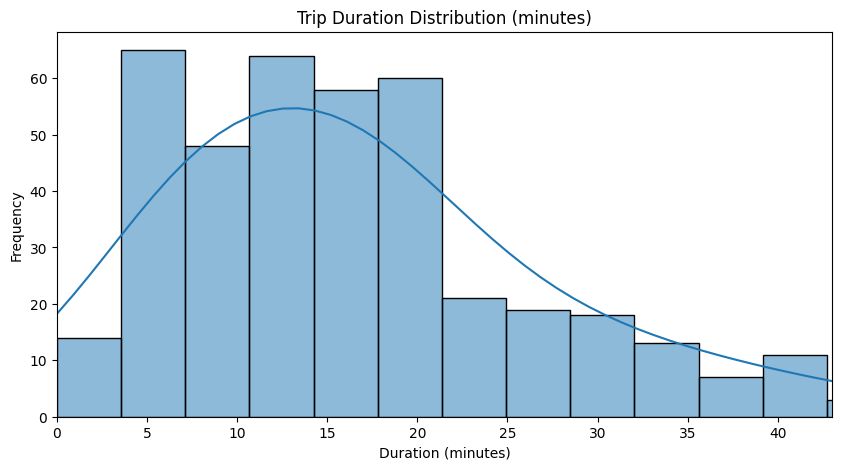

In [48]:
plt.figure(figsize=(10,5))
sns.histplot(uber['Trip_Duration_Min'], bins=50, kde=True)
plt.xlim(0, uber['Trip_Duration_Min'].quantile(0.95))
plt.title('Trip Duration Distribution (minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

2. Trips by Hour of Day

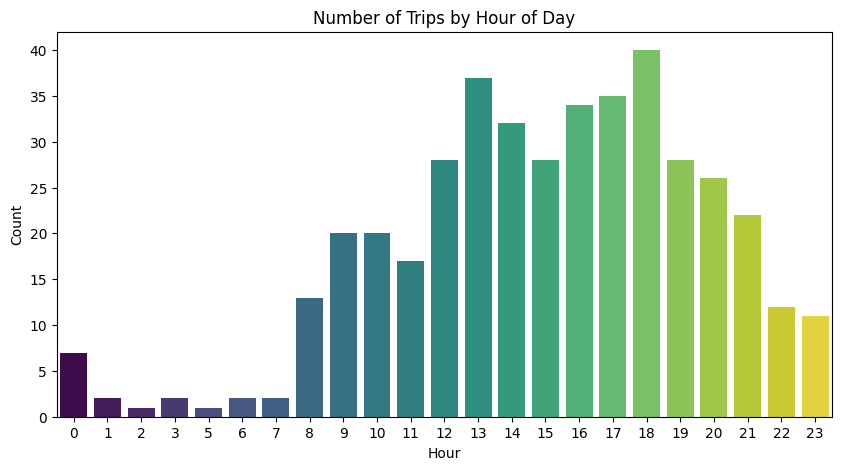

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x="Hour", hue="Hour", data=uber, palette="viridis", legend=False)
plt.title('Number of Trips by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

3. Trips by Day of Week

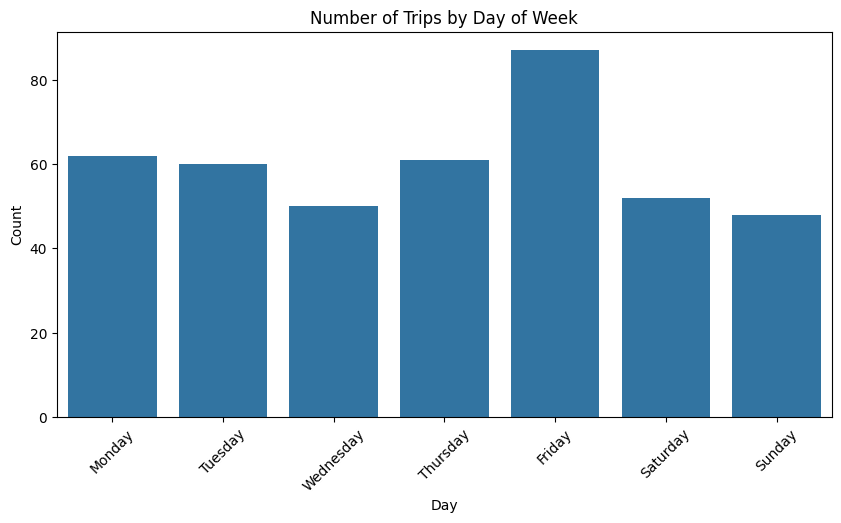

In [61]:
weekday_trips = list(calendar.day_name)
plt.figure(figsize=(10,5))
sns.countplot(x='DayOfWeek', data=uber, order=weekday_trips)
plt.title('Number of Trips by Day of Week')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Novelties

4. Rush Hour Analysis

In [62]:
def rush_hour(h):
    return 'Yes' if (7 <= h <=9) or (17 <=h <= 19) else 'No'

uber['Rush Hour'] = uber['Hour'].apply(rush_hour)


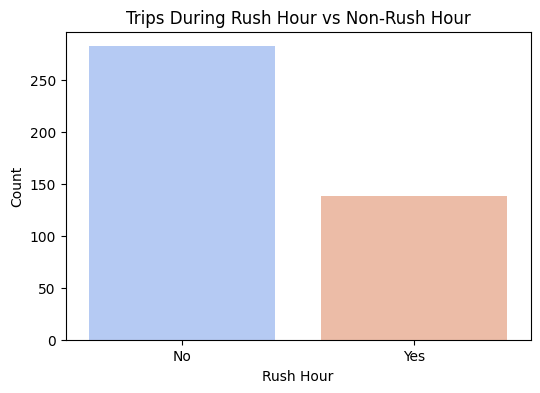

In [69]:
plt.figure(figsize=(6,4))
sns.countplot(x='Rush Hour', hue="Rush Hour", data=uber, palette='coolwarm', legend=False)
plt.title('Trips During Rush Hour vs Non-Rush Hour')
plt.xlabel('Rush Hour')
plt.ylabel('Count')
plt.show()

5. Predicting Trip Duration (Regression)

In [78]:
features = ['Hour', 'Month', 'CATEGORY_enc', 'PURPOSE_enc']
target = 'Trip_Duration_Min'

data = uber.dropna(subset=features_in_data + [target])

In [79]:
x = data[features_in_data]
y = data[target]

In [80]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

In [81]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [82]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f} minutes")
print(f"R^2 Score: {r2:.3f}")

RMSE: 20.45 minutes
R^2 Score: 0.112


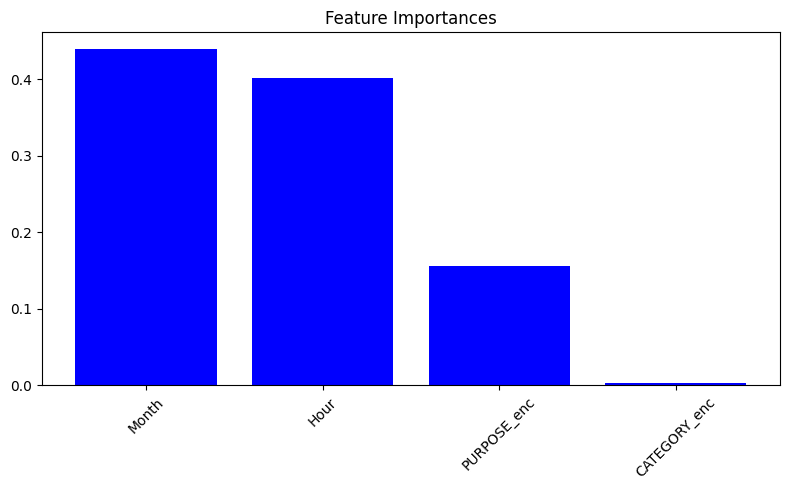

In [89]:
plt.figure(figsize=(8,5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], color="b", align="center")
plt.xticks(range(len(importances)), [features_in_data[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()